# Taichung DE forecast with LSTM

Data source :  Taichung DE PV plant, CWB WUQI weather.

Period : 2016/01/01-2017/12/31.

Frequency: 1 hour.

In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
plt.style.use('fivethirtyeight')

# Data processing

Visualizing data.

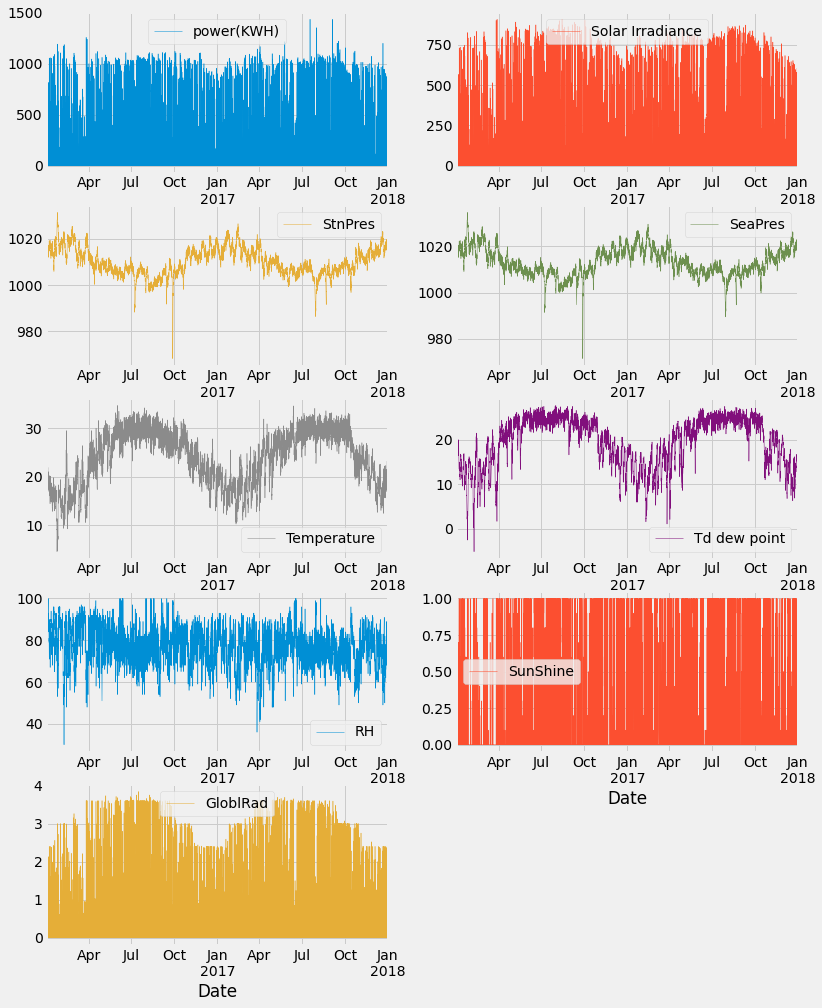

In [2]:
# quick look data
data = pd.read_csv('data\\Taichung_Power_Weather.csv', parse_dates=['Date'], index_col='Date')
# visualizing data
data.plot(subplots=True, linewidth=0.5, layout=(5, 2), figsize=(12, 16),
          sharex=False, sharey=False)
plt.show()

# Normalize

Norm min =0, max =1.

In [3]:
X_scale = MinMaxScaler(feature_range=(0, 1))
y_scale = MinMaxScaler(feature_range=(0, 1))
X_norm = X_scale.fit_transform(data.iloc[:,1:])
y_norm = y_scale.fit_transform(data.iloc[:,[0]])

In [4]:
data_scaled_X = pd.DataFrame(X_norm, index=data.index, columns=data.columns[1:])
data_scaled_y = pd.DataFrame(y_norm, index=data.index, columns=[data.columns[0]])
data_scaled = data_scaled_X.join(data_scaled_y)


Choose last 4 month to test_set.

In [5]:
Train_set, Test_set = data_scaled[:'2017-08-31'], data_scaled['2017-08-31':]

# Create lag
Create time lag.

Choose target and feature.

In [6]:
# Creating time-lagged features
def create_lag(data, pasttime, futuretime):
    X, y = [], []
    for i in range(data.shape[0]-futuretime-pasttime):
        X.append(np.array(data.iloc[i:i+pasttime,:]))
        y.append(np.array(data.iloc[i+pasttime:i+pasttime+futuretime,-1]))
    return np.array(X), np.array(y)
X_train, y_train = create_lag(Train_set , 24, 1)
X_test, y_test = create_lag(Test_set , 24, 1)

# Build model

Build LSTM model.

In [7]:
def build_Model(shape):

    model = Sequential()
    model.add(LSTM(96, input_shape=(shape[1],shape[2],), activation='relu'))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

model = build_Model(X_train.shape)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 96)                40704     
_________________________________________________________________
dense (Dense)                (None, 1)                 97        
Total params: 40,801
Trainable params: 40,801
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, y_train, epochs=1000, batch_size=128, verbose=2,  callbacks=[callback])

Epoch 1/1000
114/114 - 5s - loss: 0.0142
Epoch 2/1000
114/114 - 4s - loss: 0.0021
Epoch 3/1000
114/114 - 4s - loss: 0.0015
Epoch 4/1000
114/114 - 4s - loss: 0.0013
Epoch 5/1000
114/114 - 4s - loss: 0.0012
Epoch 6/1000
114/114 - 4s - loss: 0.0011
Epoch 7/1000
114/114 - 4s - loss: 0.0011
Epoch 8/1000
114/114 - 5s - loss: 0.0010
Epoch 9/1000
114/114 - 5s - loss: 9.8395e-04
Epoch 10/1000
114/114 - 4s - loss: 9.4716e-04
Epoch 11/1000
114/114 - 4s - loss: 9.3898e-04
Epoch 12/1000
114/114 - 4s - loss: 9.3773e-04
Epoch 13/1000
114/114 - 4s - loss: 9.2450e-04
Epoch 14/1000
114/114 - 4s - loss: 8.6591e-04
Epoch 15/1000
114/114 - 4s - loss: 8.6892e-04
Epoch 16/1000
114/114 - 4s - loss: 8.8496e-04
Epoch 17/1000
114/114 - 4s - loss: 8.5640e-04
Epoch 18/1000
114/114 - 4s - loss: 8.2249e-04
Epoch 19/1000
114/114 - 4s - loss: 8.1783e-04
Epoch 20/1000
114/114 - 4s - loss: 8.0810e-04
Epoch 21/1000
114/114 - 4s - loss: 8.8233e-04
Epoch 22/1000
114/114 - 4s - loss: 8.4342e-04
Epoch 23/1000
114/114 - 4s - 

114/114 - 4s - loss: 3.3855e-04
Epoch 179/1000
114/114 - 4s - loss: 2.9797e-04
Epoch 180/1000
114/114 - 4s - loss: 2.8632e-04
Epoch 181/1000
114/114 - 4s - loss: 2.8861e-04
Epoch 182/1000
114/114 - 4s - loss: 2.9749e-04
Epoch 183/1000
114/114 - 4s - loss: 3.0618e-04
Epoch 184/1000
114/114 - 4s - loss: 2.9164e-04
Epoch 185/1000
114/114 - 4s - loss: 3.0143e-04
Epoch 186/1000
114/114 - 4s - loss: 2.8526e-04
Epoch 187/1000
114/114 - 4s - loss: 3.1907e-04
Epoch 188/1000
114/114 - 4s - loss: 3.3823e-04
Epoch 189/1000
114/114 - 4s - loss: 3.8810e-04
Epoch 190/1000
114/114 - 4s - loss: 3.1137e-04
Epoch 191/1000
114/114 - 4s - loss: 2.9120e-04
Epoch 192/1000
114/114 - 5s - loss: 2.8923e-04
Epoch 193/1000
114/114 - 5s - loss: 2.7737e-04
Epoch 194/1000
114/114 - 4s - loss: 2.7327e-04
Epoch 195/1000
114/114 - 4s - loss: 2.7333e-04
Epoch 196/1000
114/114 - 4s - loss: 2.6679e-04
Epoch 197/1000
114/114 - 5s - loss: 2.7687e-04
Epoch 198/1000
114/114 - 5s - loss: 2.7239e-04
Epoch 199/1000
114/114 - 6s 

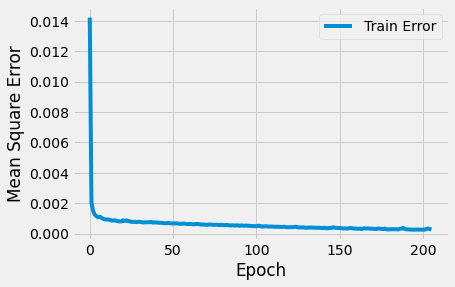

In [9]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['loss'],
             label='Train Error')
    plt.legend()

# The patience parameter is the amount of epochs to check for improvement

plot_history(history)


# Visualizing result.

In [10]:
y_test_value = y_scale.inverse_transform(y_test.reshape(-1, 1))
y_predict_norm = model.predict(X_test)
y_predict = y_scale.inverse_transform(y_predict_norm)

In [11]:
test_days = pd.DataFrame(y_test_value, index=Test_set['2017-09-01':'2017-12-31'].index, columns=['power(KWH)'])
test_days['Predicted'] = y_predict
day_time = (test_days.index.hour >= 6) & (test_days.index.hour <= 18)
test_days = test_days[day_time]

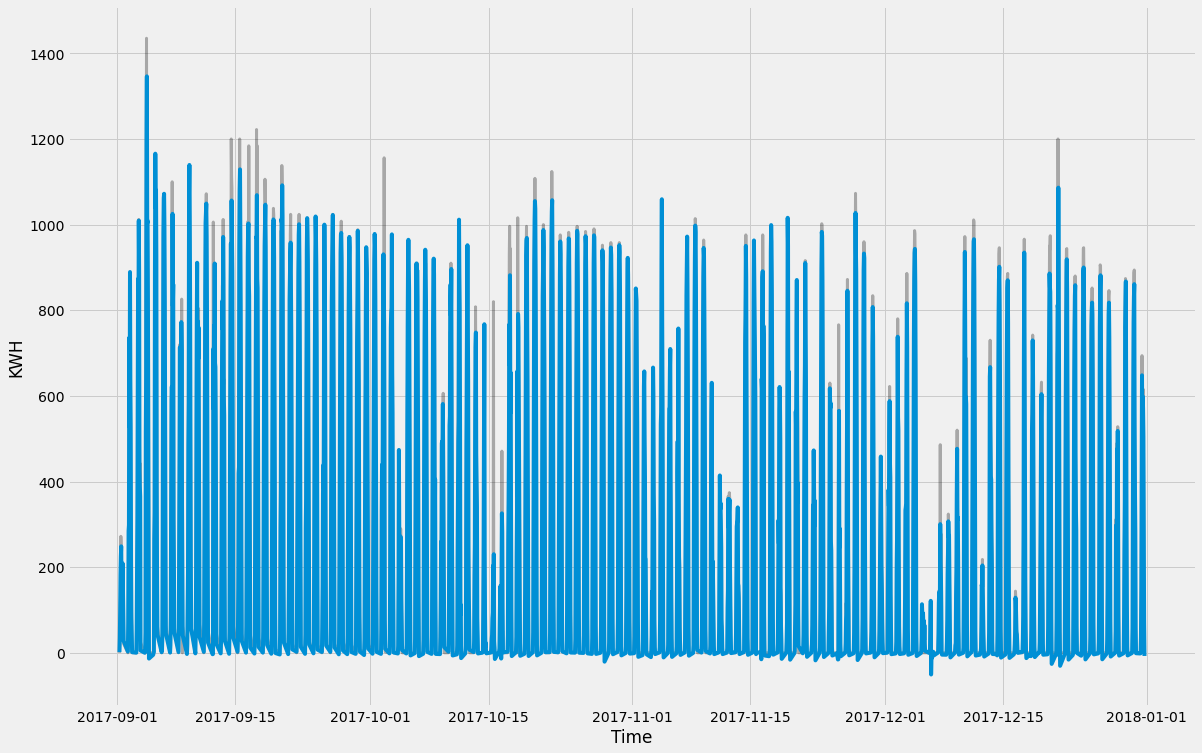

In [12]:
# visualizing predict
fig, ax = plt.subplots(figsize=(18,12))
ax.plot(test_days['power(KWH)'], color='k', alpha=.3, lw=3)
ax.plot(test_days['Predicted'])
ax.set(xlabel="Time")
ax.set(ylabel="KWH")
plt.show()

Model Score 

predict value : $ \hat{y}$  

actual value : $y$  

max of y : $y_{max}$

Mean squared error :

$$ \frac{1}{n} \sum_{k=1}^n ({y_{k} -\hat{y_{k}}})^2 $$

Mean absoluate error :

$$ \frac{1}{n} \sum_{k=1}^n \vert {y_{k} -\hat{y_{k}}} \vert $$

Mean relative error :

$$ \frac{100\%}{n} \sum_{k=1}^n \frac{{y_{k} -\hat{y_{k}}}}{y_{max}}  $$

Coefficient of determination :

$$ R^{2} \equiv 1 - \frac {SS_{res}}{SS_{tot}}$$

$$SS_{res} = \sum_{k=1}^n  { (\hat{y_{k}} - \tilde {y})^2}   ,SS_{tot} = \sum_{k=1}^n  { ({y_{k}} - \tilde {y})^2} 
, \tilde {y} = \frac{1}{n} \sum_{k=1}^n {y_{k}} $$

<!-- Mean absoluate percentage error :

% $$ \frac{100\%}{n} \sum_{k=1}^n \vert \frac{{y_{k} -\hat{y_{k}}}}{y_{k}} \vert $$ -->

In [13]:
def MRE(x,y):
    return np.nanmean(np.abs((x-y)/np.max(x)))

def print_results(y_test, y_predict):
    print('Root mean squared error:{:.4f}'.format(np.sqrt(mean_squared_error(y_test,y_predict))))
    print('Mean absolute error:{:.4f}'.format(mean_absolute_error(y_test,y_predict)))
    print('Mean relative error:{:.2%}'.format(MRE(y_test,y_predict)))
    print('Coefficient of determination:{:.4f}'.format(r2_score(y_test,y_predict)))

print_results(test_days['power(KWH)'], test_days['Predicted'])

Root mean squared error:85.7867
Mean absolute error:38.3409
Mean relative error:2.67%
Coefficient of determination:0.9406


# Look at Worst and Best Predicted Days

In [14]:
test_days['error'] = test_days['power(KWH)'] - test_days['Predicted']
test_days['abs_error'] = test_days['error'].apply(np.abs)
test_days['year']=test_days.index.year
test_days['month']=test_days.index.month
test_days['day']=test_days.index.day

error_by_day = test_days.groupby(['year','month','day']).mean()[['power(KWH)','Predicted','error','abs_error']]

Looking worst predicted ten days.

In [15]:
def look_ten(data, Best=True):
    top_ten=data.sort_values('abs_error', ascending=Best).head(10)
    top_date = top_ten.index[0]
    top_date = str(top_date[0])+'-'+str(top_date[1])+'-'+str(top_date[2])
    print(top_ten)
    return top_date

# Worst absolute predicted days
Worst_date = look_ten(error_by_day, Best=False)

                power(KWH)   Predicted      error   abs_error
year month day                                               
2017 10    18   355.076923  347.307678   7.769244  175.267659
     9     7    378.384615  425.148254 -46.763634  166.156299
     10    11   384.307692  387.976471  -3.668792  147.474267
     11    16   412.769231  373.601776  39.167448  138.686589
     10    17   449.461538  391.598297  57.863230  130.299084
     9     4    616.630936  572.913269  43.717678  130.182501
     11    19   406.923077  315.119537  91.803537  128.638887
           18   154.307692  249.870422 -95.562725  113.172713
           20   347.538462  323.985138  23.553317  112.718514
     10    2    407.307692  436.933838 -29.626141  106.777579


Looking best predicted ten days.

In [16]:
# Best predicted days
Best_date = look_ten(error_by_day, Best=True)

                power(KWH)   Predicted     error  abs_error
year month day                                             
2017 11    12   181.461538  177.437241  4.024301   5.519047
     9     29   465.692308  466.004395 -0.312101   5.603358
     11    13   144.615385  149.344193 -4.728806   6.223733
     12    16    42.000000   39.460892  2.539108   6.528756
     11    24   227.923077  224.877701  3.045372   6.945267
     12    12    72.461538   66.542206  5.919329   7.361764
     11    22   191.538462  196.410904 -4.872441   7.857340
     10    29   479.230769  474.348877  4.881903   7.987830
           26   505.615385  497.825989  7.789401   8.423788
     11    11   157.000000  160.366684 -3.366683   8.479600


# Plotting best/worst predicted days
Plotting worst predicted day.

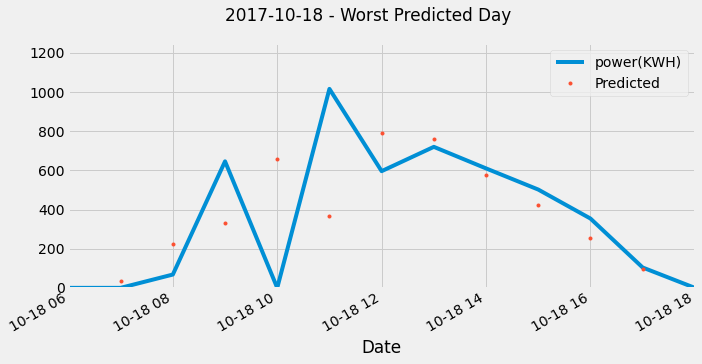

In [17]:
def plot_one(data, day, title):
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(10)
    _ = data[['power(KWH)','Predicted']].plot(ax=ax, style=['-','.'])
    ax.set_ylim(0, 1250)
    ax.set_xbound(lower=day+' 06:00', upper=day +' 18:00')
    plot = plt.suptitle(day+ ' - ' + title +' Predicted Day ')

# plot worst day
plot_one(test_days, Worst_date, 'Worst')

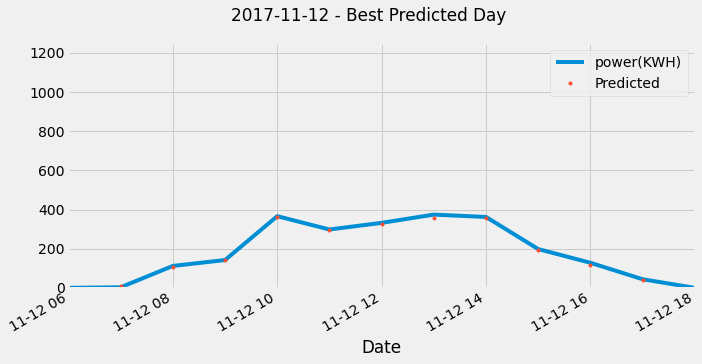

In [18]:
# plot best day
plot_one(test_days, Best_date, 'Best')